<a href="https://colab.research.google.com/github/matheusrbg/Reconhecimento-do-Alfabeto-em-Libras/blob/main/vgg19bn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, transforms
from torch.optim import lr_scheduler
from torch.utils.data.sampler import SubsetRandomSampler
from tqdm.notebook import tqdm
import os
import time
import copy
import matplotlib.pyplot as plt

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
use_gpu = torch.cuda.is_available()
use_gpu

True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# !unzip -n /content/drive/MyDrive/LIBRAS/test.zip -d /content/drive/MyDrive/LIBRAS/ 

# Preprocessing

In [3]:
transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1, hue=0.1),
        transforms.RandomAffine(degrees=40, translate=None, scale=(1, 2), shear=15),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

transform_test = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

In [4]:
data_dir = "drive/MyDrive/LIBRAS"
num_workers = 4

image_datasets = {
    'train': datasets.ImageFolder(
        root=os.path.join(data_dir, 'train'), 
        transform=transform
    ),
    'val': datasets.ImageFolder(
        root=os.path.join(data_dir, 'validation'), 
        transform=transform_test
    ),
    'test': datasets.ImageFolder(
        root=os.path.join(data_dir, 'test'), 
        transform=transform_test
    )
}
dataloaders = {
    'train': torch.utils.data.DataLoader(
        image_datasets['train'], batch_size=300,
        shuffle=True, num_workers=num_workers
    ),
    'val': torch.utils.data.DataLoader(
        image_datasets['val'], batch_size=128,
        shuffle=True, num_workers=num_workers
    ),
    'test': torch.utils.data.DataLoader(
        image_datasets['test'], batch_size=128,
        shuffle=True, num_workers=num_workers
    )
}
pathloaders = {
    'train': torch.utils.data.DataLoader(
        image_datasets['train'].imgs, batch_size=300,
        shuffle=True, num_workers=num_workers
    ),
    'val': torch.utils.data.DataLoader(
        image_datasets['val'].imgs, batch_size=128,
        shuffle=True, num_workers=num_workers
    ),
    'test': torch.utils.data.DataLoader(
        image_datasets['test'].imgs, batch_size=128,
        shuffle=True, num_workers=num_workers
    ),
}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test', 'val']}

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'drive/MyDrive/LIBRAS\\train'

In [7]:
for x in ['train', 'test', 'val']:
    print("Loaded {} images in {}".format(dataset_sizes[x], x))
    
print("Classes: ")

label = image_datasets['test'].classes
print(image_datasets['train'].classes)
print(label)

Loaded 34714 images in train
Loaded 5783 images in test
Loaded 5738 images in val
Classes: 
['A', 'B', 'C', 'D', 'E', 'F', 'G', 'I', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'Y']
['A', 'B', 'C', 'D', 'E', 'F', 'G', 'I', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'Y']


# Creating Model

In [8]:
num_classes = len(os.listdir(data_dir + '/train'))
num_epochs = 5
learning_rate = 0.0005
weight_decay = 5e-4

model = torchvision.models.resnet34(weights='IMAGENET1K_V1')

model.fc = torch.nn.Linear(model.fc.in_features, num_classes)
torch.nn.init.xavier_uniform_(model.fc.weight)

if use_gpu:
  model.to(device)

criterion = torch.nn.CrossEntropyLoss()
# params_1x are the parameters of the network body, i.e., of all layers except the FC layers
params_1x = [param for name, param in model.named_parameters() if 'fc' not in str(name)]
optimizer = torch.optim.Adam([{'params':params_1x}, {'params': model.fc.parameters(), 'lr': learning_rate*10}], lr=learning_rate, weight_decay=weight_decay)


# Training

In [9]:
def train_model(model, criterion, optimizer, num_epochs=5):
    if use_gpu:
        with torch.no_grad():
            model = model.to(device)

    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    avg_loss = 0
    avg_acc = 0
    avg_loss_val = 0
    avg_acc_val = 0
    
    train_batches = len(dataloaders['train'])
    
    loss_values = []
    acc_values = []
    for epoch in tqdm(range(num_epochs)):
        print("Epoch {}/{}".format(epoch, num_epochs-1))
        print('-' * 10)
        
        loss_train = 0
        loss_val = 0
        acc_train = 0
        
        model.train(True)
        pbar = tqdm(total=train_batches)
        for i, data in enumerate(dataloaders['train']):
            pbar.update(1)
                            
            inputs, labels= data
            
            if use_gpu:
                with torch.no_grad():
                    inputs, labels = inputs.cuda(), labels.cuda()
            else:
                with torch.no_grad():
                    inputs, labels = inputs, labels
            
            optimizer.zero_grad()
            
            outputs = model(inputs)
            
            _, preds = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            
            loss_train += loss.item()
            acc_train += torch.sum(preds == labels.data)
            
            del inputs, labels, outputs, preds
            torch.cuda.empty_cache()

        avg_loss = loss_train  / dataset_sizes['train']
        avg_acc = acc_train  / dataset_sizes['train']
        loss_values.append((avg_loss, avg_loss_val))
        acc_values.append((avg_acc, avg_acc_val))
        model.train(False)
        model.eval()

        print("Running validation")
        y_true = []
        y_pred = []
        avg_loss_val = 0
        avg_acc_val = 0
        loss_test = 0
        acc_test = 0
        pbar = tqdm(total=len(dataloaders['val']))
        for i, data in enumerate(dataloaders['val']):
          pbar.update(1)
          
          inputs, labels = data
          
          y_true = y_true + labels.tolist()
          if use_gpu:
              with torch.no_grad():
                  inputs, labels = inputs.cuda(), labels.cuda()
          else:
              with torch.no_grad():
                  inputs, labels = inputs, labels
          
          outputs = model(inputs)

          _, preds = torch.max(outputs.data, 1)
          loss = criterion(outputs, labels)
          #print(preds)
          y_pred = y_pred + preds.tolist()
          
          loss_test += loss.item()
          acc_test += torch.sum(preds == labels.data)

          del inputs, labels, outputs, preds
          torch.cuda.empty_cache()

        avg_loss_val = loss_test / dataset_sizes['val']
        avg_acc_val = acc_test / dataset_sizes['val']
        print("Epoch {} result: ".format(epoch))
        print("Avg loss (validation): {:.4f}".format(avg_loss_val))
        print("Avg acc (validation): {:.4f}".format(avg_acc_val))
        
        print()
        print("Avg loss (train): {:.4f}".format(avg_loss))
        print("Avg acc (train): {:.4f}".format(avg_acc))

        print('-' * 10)
        print()
        
        if avg_acc_val > best_acc:
            best_acc = avg_acc_val
            best_model_wts = copy.deepcopy(model.state_dict())
        
    elapsed_time = time.time() - since
    print()
    print("Training completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))
    print("Best acc: {:.4f}".format(best_acc))
    
    model.load_state_dict(best_model_wts)
    return model,acc_values,loss_values

In [10]:
model,acc,loss = train_model(model, criterion, optimizer, num_epochs=num_epochs)
torch.save(model.state_dict(),'resnet_libras.pt')

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 0/4
----------


  0%|          | 0/116 [00:00<?, ?it/s]

Running validation


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch 0 result: 
Avg loss (validation): 0.0013
Avg acc (validation): 0.9367

Avg loss (train): 0.0008
Avg acc (train): 0.9395
----------

Epoch 1/4
----------


  0%|          | 0/116 [00:00<?, ?it/s]

Running validation


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch 1 result: 
Avg loss (validation): 0.0004
Avg acc (validation): 0.9868

Avg loss (train): 0.0001
Avg acc (train): 0.9934
----------

Epoch 2/4
----------


  0%|          | 0/116 [00:00<?, ?it/s]

Running validation


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch 2 result: 
Avg loss (validation): 0.0006
Avg acc (validation): 0.9756

Avg loss (train): 0.0000
Avg acc (train): 0.9967
----------

Epoch 3/4
----------


  0%|          | 0/116 [00:00<?, ?it/s]

Running validation


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch 3 result: 
Avg loss (validation): 0.0007
Avg acc (validation): 0.9742

Avg loss (train): 0.0000
Avg acc (train): 0.9963
----------

Epoch 4/4
----------


  0%|          | 0/116 [00:00<?, ?it/s]

Running validation


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch 4 result: 
Avg loss (validation): 0.0008
Avg acc (validation): 0.9707

Avg loss (train): 0.0001
Avg acc (train): 0.9947
----------


Training completed in 41m 39s
Best acc: 0.9868


Text(0.5, 1.0, 'ResNet loss')

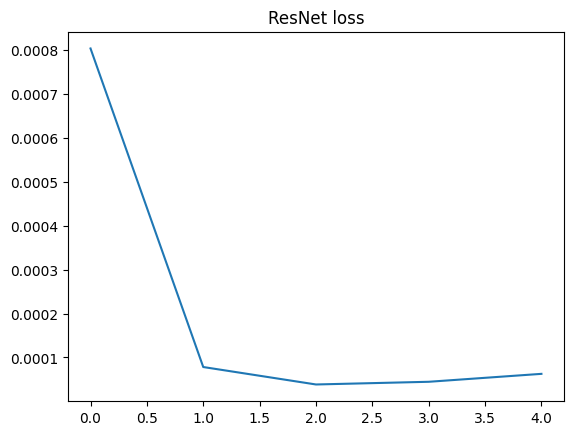

In [28]:
plt.plot([it[0] for it in loss])
plt.title("ResNet loss")

In [18]:
!ls

drive  resnet_libras.pt  sample_data


In [19]:
!cp  resnet_libras.pt drive/MyDrive/LIBRAS

# Evaluating

In [29]:
PATH = "drive/MyDrive/LIBRAS/resnet_libras.pt"
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [30]:
def eval_model(model, criterion):
    if use_gpu:
        with torch.no_grad():
            model = model.to(device)

    y_true = []
    y_pred = []
    since = time.time()
    avg_loss = 0
    avg_acc = 0
    loss_test = 0
    acc_test = 0
    
    test_batches = len(dataloaders['test'])
    print("Evaluating model")
    print('-' * 10)
    pbar = tqdm(total=test_batches)
    for i, data in enumerate(dataloaders['test']):
        pbar.update(1)

        model.train(False)
        model.eval()
        
        inputs, labels = data
        
        y_true = y_true + labels.tolist()
        if use_gpu:
            with torch.no_grad():
                inputs, labels = inputs.cuda(), labels.cuda()
        else:
            with torch.no_grad():
                inputs, labels = inputs, labels
        
        outputs = model(inputs)

        _, preds = torch.max(outputs.data, 1)
        loss = criterion(outputs, labels)
        #print(preds)
        y_pred = y_pred + preds.tolist()
        
        loss_test += loss.item()
        acc_test += torch.sum(preds == labels.data)

        del inputs, labels, outputs, preds
        torch.cuda.empty_cache()
        
    avg_loss = loss_test / dataset_sizes['test']
    avg_acc = acc_test / dataset_sizes['test']
    
    elapsed_time = time.time() - since
    print()
    print("Evaluation completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))
    print("Avg loss (test): {:.4f}".format(avg_loss))
    print("Avg acc (test): {:.4f}".format(avg_acc))
    print('-' * 10)

In [31]:
criterion = nn.CrossEntropyLoss()
eval_model(model, criterion)

Evaluating model
----------


  0%|          | 0/46 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(



Evaluation completed in 0m 22s
Avg loss (test): 0.0004
Avg acc (test): 0.9853
----------
